#### Import libraries and dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_trainclass), (x_test, y_testclass) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# Def plot 1000 -> 1005
def plot(first_title, x, second_title, y):
    plt.figure(figsize=(10, 10))
    for i in range(5):
        ax = plt.subplot(5, 5, i + 1)
        plt.title(first_title)
        plt.imshow(tf.squeeze(x[1000+i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, 5, i + 1 + 5)
        plt.imshow(y[i])
        plt.title(second_title)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### Checkout sample

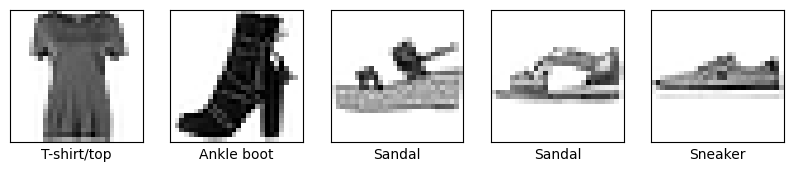

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(10,15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_trainclass[i]])
plt.show()

#### Create autoencoder

In [5]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Lambda, Flatten, Dropout, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mse

In [6]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(input_img)
x = Conv2D(64, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(x)
x = Flatten()(x)
encoded = Dense(64)(x)
encoder = Model(inputs=input_img, outputs=encoded)

encoded_inputs = Input(shape=(64,))

x = Dense(7*7*64, activation='relu')(encoded_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
decoded = Conv2DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = Model(inputs=encoded_inputs, outputs=decoded)

x = encoder(input_img)
x = decoder(x)
autoencoder = Model(inputs=input_img, outputs=x)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])

In [7]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')/255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')/255.0

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25
469/469 [==============================] - 86s 177ms/step - loss: 0.3255 - accuracy: 0.5033 - mse: 0.0288 - val_loss: 0.2844 - val_accuracy: 0.5052 - val_mse: 0.0136
Epoch 2/25
469/469 [==============================] - 83s 176ms/step - loss: 0.2757 - accuracy: 0.5082 - mse: 0.0114 - val_loss: 0.2733 - val_accuracy: 0.5064 - val_mse: 0.0099
Epoch 3/25
469/469 [==============================] - 83s 177ms/step - loss: 0.2684 - accuracy: 0.5088 - mse: 0.0090 - val_loss: 0.2689 - val_accuracy: 0.5068 - val_mse: 0.0085
Epoch 4/25
469/469 [==============================] - 82s 174ms/step - loss: 0.2647 - accuracy: 0.5091 - mse: 0.0078 - val_loss: 0.2657 - val_accuracy: 0.5069 - val_mse: 0.0075
Epoch 5/25
469/469 [==============================] - 81s 172ms/step - loss: 0.2626 - accuracy: 0.5092 - mse: 0.0071 - val_loss: 0.2642 - val_accuracy: 0.5070 - val_mse: 0.0070
Epoch 6/25
469/469 [==============================] - 82s 174ms/step - loss: 0.2611 - accuracy: 0.5093 - mse: 0.006

1/1 [==============================] - 0s 150ms/step


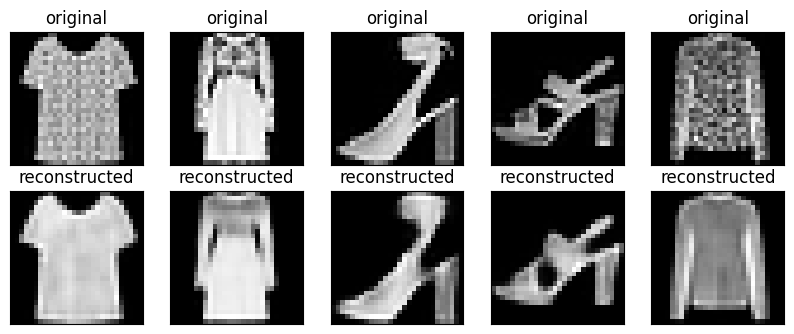

In [9]:
y_test = autoencoder.predict(x_test[1000:1005])
plot("original", x_test, "reconstructed", y_test)

#### Denoising

In [10]:
# Create noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

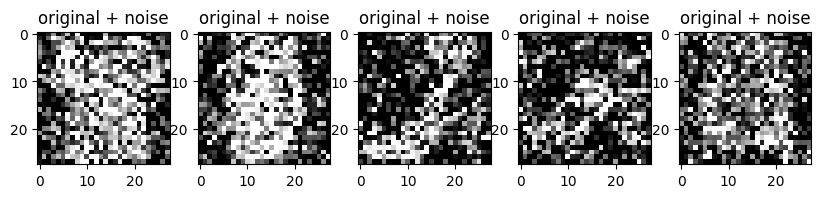

In [11]:
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(5, 5, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[1000+i]))
    plt.gray()
plt.show()

In [12]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 96s 51ms/step - loss: 0.2880 - accuracy: 0.5075 - mse: 0.0150 - val_loss: 0.2860 - val_accuracy: 0.5055 - val_mse: 0.0138
Epoch 2/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.2824 - accuracy: 0.5080 - mse: 0.0133 - val_loss: 0.2845 - val_accuracy: 0.5059 - val_mse: 0.0133
Epoch 3/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.2807 - accuracy: 0.5082 - mse: 0.0128 - val_loss: 0.2842 - val_accuracy: 0.5057 - val_mse: 0.0132
Epoch 4/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.2796 - accuracy: 0.5083 - mse: 0.0125 - val_loss: 0.2840 - val_accuracy: 0.5056 - val_mse: 0.0132
Epoch 5/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.2787 - accuracy: 0.5083 - mse: 0.0122 - val_loss: 0.2836 - val_accuracy: 0.5057 - val_mse: 0.0131
Epoch 6/10
1875/1875 [==============================] - 99s 53ms/step - loss: 0.2780 - accuracy: 0.5084 - mse:

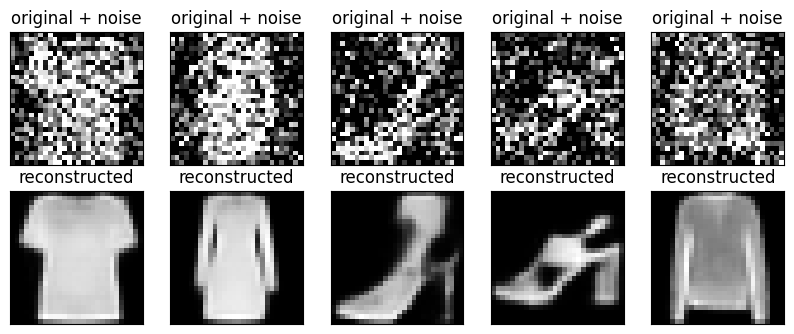

In [13]:
y_test = autoencoder.predict(x_test_noisy[1000:1005], verbose=False)
plot("original + noise", x_test_noisy, "reconstructed", y_test)

#### Super-resolution

In [14]:
x_train_lr = tf.keras.layers.AveragePooling2D()(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D()(x_test).numpy()


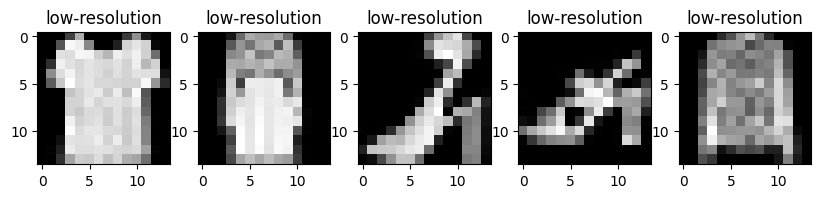

In [15]:
plt.figure(figsize=(10, 10))
for i in range(5):
    ax = plt.subplot(5, 5, i + 1)
    plt.title("low-resolution")
    plt.imshow(tf.squeeze(x_test_lr[1000+i]))
    plt.gray()
plt.show()

In [16]:
input_img = Input(shape=(14, 14, 1))

x = Conv2D(32, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(input_img)
x = Conv2D(64, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(x)
x = Flatten()(x)
encoded = Dense(64)(x)
encoder = Model(inputs=input_img, outputs=encoded)

encoded_inputs = Input(shape=(64,))

x = Dense(7*7*64, activation='relu')(encoded_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=(2, 2), padding='same', activation='relu')(x)
decoded = Conv2DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = Model(inputs=encoded_inputs, outputs=decoded)

x = encoder(input_img)
x = decoder(x)
autoencoder = Model(inputs=input_img, outputs=x)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])

In [17]:
autoencoder.fit(x_train_lr, x_train,
               epochs=25,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test_lr, x_test))

Epoch 1/25
469/469 [==============================] - 78s 162ms/step - loss: 0.3305 - accuracy: 0.5031 - mse: 0.0304 - val_loss: 0.2870 - val_accuracy: 0.5049 - val_mse: 0.0144
Epoch 2/25
469/469 [==============================] - 74s 158ms/step - loss: 0.2786 - accuracy: 0.5080 - mse: 0.0123 - val_loss: 0.2760 - val_accuracy: 0.5062 - val_mse: 0.0108
Epoch 3/25
469/469 [==============================] - 74s 157ms/step - loss: 0.2716 - accuracy: 0.5086 - mse: 0.0100 - val_loss: 0.2717 - val_accuracy: 0.5067 - val_mse: 0.0093
Epoch 4/25
469/469 [==============================] - 75s 160ms/step - loss: 0.2681 - accuracy: 0.5089 - mse: 0.0088 - val_loss: 0.2691 - val_accuracy: 0.5068 - val_mse: 0.0085
Epoch 5/25
469/469 [==============================] - 74s 157ms/step - loss: 0.2660 - accuracy: 0.5091 - mse: 0.0081 - val_loss: 0.2673 - val_accuracy: 0.5069 - val_mse: 0.0079
Epoch 6/25
469/469 [==============================] - 74s 158ms/step - loss: 0.2645 - accuracy: 0.5092 - mse: 0.007

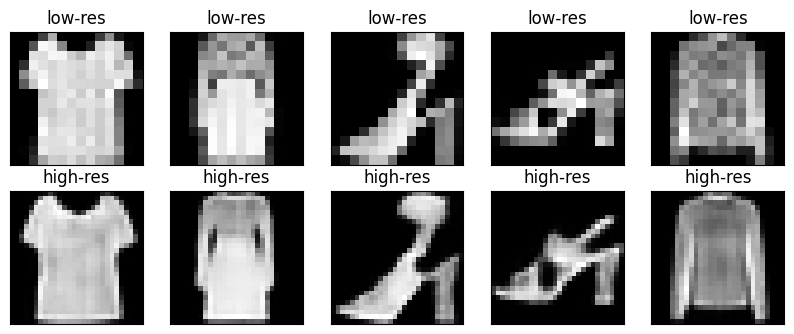

In [18]:
y_test_lr = autoencoder.predict(x_test_lr[1000:1005], verbose=False)
plot("low-res", x_test_lr, "high-res", y_test_lr)